# Red Neuronal Recurrente para clasificacion de numeros en imagenes
El proyecto esta basado en la creacion de una RNN para hacer la clasificacion de imagenes que contienen numero.

Usamos el set de datos mnist para el entrenamiento del modelo.

Durante el proyecto se llego a la conclusion de que seria viable llevar a produccion este modelo ya que tiene una precisión (accuracy) del 99.13%, con un intervalo de confianza para la precisión que varía entre 98.95% y 99.32%, lo que sugiere que, para datos nuevos, se espera que el rendimiento del modelo se mantenga dentro de este rango con un nivel de confianza adecuado.

Esto significa que la posibilidad a que clasifique un numero mal sera de 2 en 100 imagenes.

In [19]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import matplotlib.pyplot as plt
import seaborn as sns
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

import IPython
import warnings
warnings.filterwarnings("ignore", message="Do not pass an `input_shape`/`input_dim` argument to a layer.")

In [58]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

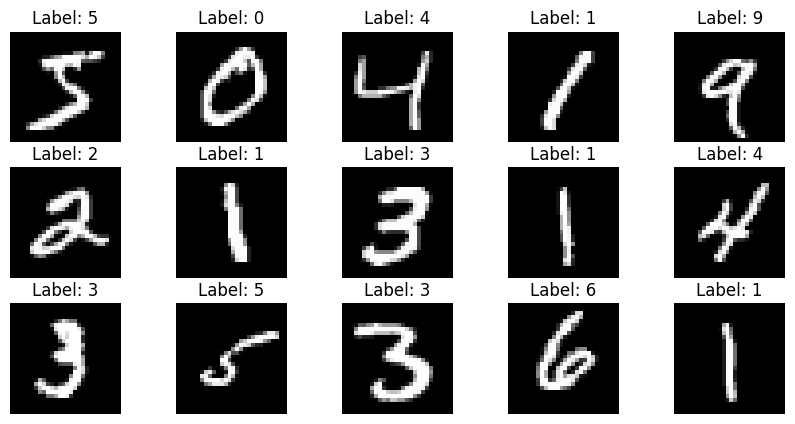

In [8]:
# Visualizar algunos ejemplos
fig, axes = plt.subplots(3, 5, figsize=(10, 5))
axes = axes.ravel()

for i in np.arange(15):
    axes[i].imshow(X_train[i], cmap='gray')
    axes[i].set_title(f"Label: {y_train[i]}")
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)
plt.show()

Aqui podemos bservar que se trata de imagenes de numeros

# Analisis exploratorio de los datos (EDA)

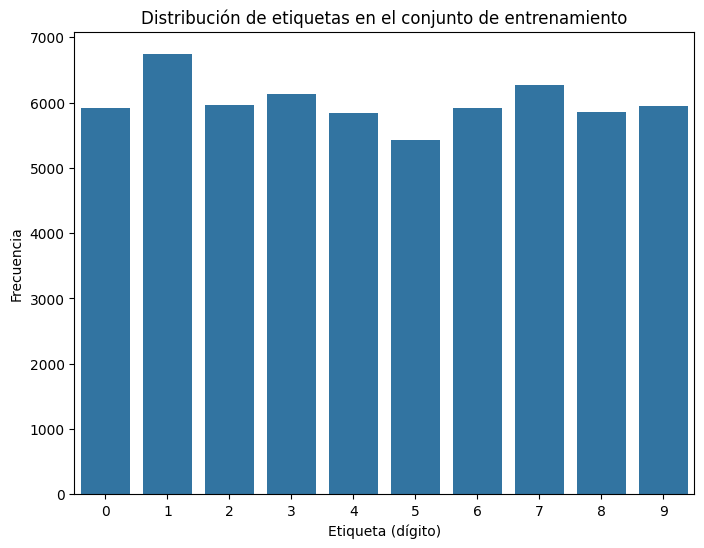

In [9]:
# Graficar la distribución de las etiquetas en el conjunto de entrenamiento
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train)
plt.title('Distribución de etiquetas en el conjunto de entrenamiento')
plt.xlabel('Etiqueta (dígito)')
plt.ylabel('Frecuencia')
plt.show()

Aqui podemos observar que hay una cantidad distribuida similar entre ellas

In [11]:
# Verificar los valores de los píxeles
print(f'Valor mínimo de píxel: {np.min(X_train)}')
print(f'Valor máximo de píxel: {np.max(X_train)}')
print(f'Valor promedio de píxel: {np.mean(X_train)}')

Valor mínimo de píxel: 0
Valor máximo de píxel: 255
Valor promedio de píxel: 33.318421449829934


## Normalizacion

In [59]:
# Normalizar las imágenes para que estén en el rango [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Verificar el rango después de la normalización
print(f'Valor mínimo de píxel (normalizado): {np.min(X_train_normalized)}')
print(f'Valor máximo de píxel (normalizado): {np.max(X_train_normalized)}')

Valor mínimo de píxel (normalizado): 0.0
Valor máximo de píxel (normalizado): 0.003921568859368563


# Busqueda del mejor modelo

In [22]:
X_val_train, X_val_test, y_val_train, y_val_test = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

In [30]:
# Crear el modelo
def create_model(optimizer='adam', neurons_layer1=128, neurons_layer2=64):
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28)))  # Aplanar la imagen de 28x28 píxeles
    model.add(Dense(neurons_layer1, activation='relu'))  # Cantidad de neuronas de la primera capa
    model.add(Dense(neurons_layer2, activation='relu'))  # Cantidad de neuronas de la segunda capa
    model.add(Dense(10, activation='softmax'))  # Capa de salida para 10 clases
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Crear el modelo para usar con GridSearchCV
model = KerasClassifier(build_fn=create_model, verbose=0)

# Definir los hiperparámetros para buscar
param_grid = {
    'batch_size': [32, 64],
    'epochs': [10, 20],
    'optimizer': ['adam', 'sgd'],
    'neurons_layer1': [64, 128, 256],
    'neurons_layer2': [32, 64, 128]
}


# Realizar GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X_val_train, y_val_train)  # Asegúrate de tener X_train_normalized preparado

# Mostrar los mejores resultados encontrados
print(f"Mejores parámetros: {grid_result.best_params_}")
print(f"Mejor score de validación: {grid_result.best_score_}")


ValueError: Invalid parameter neurons_layer1 for estimator KerasClassifier.
This issue can likely be resolved by setting this parameter in the KerasClassifier constructor:
`KerasClassifier(neurons_layer1=64)`
Check the list of available parameters with `estimator.get_params().keys()`

Al intentar hacer correr un GridsearchCV, para que haga pruebas de las capas con diferentes cantidad de neuronas, opte por probar con hyperband

In [36]:
import keras
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def crear_modelo(hp):
    # Arquitectura del modelo
    modelo = Sequential()

    # Cargamos la capa de entrada (tamaño de las imágenes 28x28, en escala de grises)
    modelo.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), name="Entrada"))

    # Cargamos los valores de los hiperparámetros
    hp_initializer = hp.Choice('kernel_initializer', values=['glorot_uniform'])
    
    hp_activation = hp.Choice('activation', values=['relu', 'swish'])
    
    hp_optimizer = hp.Choice('optimizer', values=['sgd', 'adam'])

    hp_neuronas_1 = hp.Int(name='units_1', min_value=32, max_value=128, step=32)  # Aumentamos el rango
    hp_neuronas_2 = hp.Int(name='units_2', min_value=32, max_value=128, step=32)
    hp_neuronas_3 = hp.Int(name='units_3', min_value=32, max_value=128, step=32)

    # Capa Convolucional
    modelo.add(Conv2D(filters=hp_neuronas_1, kernel_size=(3, 3), activation=hp_activation, kernel_initializer=hp_initializer))

    # Capa de MaxPooling
    modelo.add(MaxPooling2D(pool_size=(2, 2)))

    # Capa Convolucional adicional
    modelo.add(Conv2D(filters=hp_neuronas_2, kernel_size=(3, 3), activation=hp_activation, kernel_initializer=hp_initializer))

    # Capa de MaxPooling
    modelo.add(MaxPooling2D(pool_size=(2, 2)))

    # Aplanamiento de la salida para conectarse con las capas densas
    modelo.add(Flatten())

    # Capas densas
    modelo.add(Dense(units=hp_neuronas_3, activation=hp_activation, kernel_initializer=hp_initializer))
    
    modelo.add(Dense(units=hp_neuronas_2, activation=hp_activation, kernel_initializer=hp_initializer))
    
    modelo.add(Dense(units=hp_neuronas_1, activation=hp_activation, kernel_initializer=hp_initializer))

    # Capa de salida (para clasificación de 10 clases con softmax)
    modelo.add(Dense(units=10, kernel_initializer=hp_initializer, activation="softmax", name="Salida"))

    # Compilación del modelo
    modelo.compile(loss="sparse_categorical_crossentropy", optimizer=hp_optimizer, metrics=['accuracy'])

    return modelo

In [39]:
tuner=kt.Hyperband(crear_modelo,
                     objective = 'val_loss',
                     max_epochs = 50,
                     factor = 3,
                     directory = r'C:\Users\gaspa\OneDrive\Escritorio\Facu\AA3\Hyperband',
                     project_name = 'AA3_classification_2',
                     max_consecutive_failed_trials=10)
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

In [40]:
tuner.search(X_val_train, y_val_train, epochs=500, validation_data=(X_val_test, y_val_test))

Trial 73 Complete [00h 05m 48s]
val_loss: 0.040151577442884445

Best val_loss So Far: 0.031731605529785156
Total elapsed time: 02h 00m 26s

Search: Running Trial #74

Value             |Best Value So Far |Hyperparameter
glorot_uniform    |glorot_uniform    |kernel_initializer
swish             |relu              |activation
adam              |adam              |optimizer
128               |128               |units_1
96                |128               |units_2
32                |32                |units_3
50                |6                 |tuner/epochs
17                |2                 |tuner/initial_epoch
2                 |3                 |tuner/bracket
2                 |1                 |tuner/round
0070              |0001              |tuner/trial_id

Epoch 18/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.9912 - loss: 0.0282 - val_accuracy: 0.9883 - val_loss: 0.0421
Epoch 19/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 33s 22ms/step - accuracy: 0.9930 - loss: 0.0222

KeyboardInterrupt: 

Debido a que al tiempo de procesamiemto que fue mayor a 2 horas, seleccione el modelo de mejor resultado durante que la busqueda continuo activa.

El modelo seleccionado seria glorot_uniform, relu, adam, 128, 128, 32, 6, 2, 3

In [41]:
mejores_hiperparametros = tuner.get_best_hyperparameters(num_trials = 1)[0]

## Los mejores hyperparametros

In [42]:
mejores_hiperparametros.values

{'kernel_initializer': 'glorot_uniform',
 'activation': 'relu',
 'optimizer': 'adam',
 'units_1': 128,
 'units_2': 128,
 'units_3': 32,
 'tuner/epochs': 6,
 'tuner/initial_epoch': 2,
 'tuner/bracket': 3,
 'tuner/round': 1,
 'tuner/trial_id': '0001'}

# Prueba de la mejor arquitectura

In [64]:
mejor_arquitectura = tuner.hypermodel.build(mejores_hiperparametros)

mejor_arquitectura.compile(loss="sparse_categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

history = mejor_arquitectura.fit(X_train, y_train, epochs=6,
                    validation_data=(X_test, y_test))

Epoch 1/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 14ms/step - accuracy: 0.8985 - loss: 0.3090 - val_accuracy: 0.9845 - val_loss: 0.0499
Epoch 2/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.9864 - loss: 0.0451 - val_accuracy: 0.9917 - val_loss: 0.0291
Epoch 3/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - accuracy: 0.9898 - loss: 0.0334 - val_accuracy: 0.9881 - val_loss: 0.0382
Epoch 4/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - accuracy: 0.9927 - loss: 0.0235 - val_accuracy: 0.9922 - val_loss: 0.0261
Epoch 5/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - accuracy: 0.9943 - loss: 0.0184 - val_accuracy: 0.9915 - val_loss: 0.0307
Epoch 6/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - accuracy: 0.9948 - loss: 0.0174 - val_accuracy: 0.9913 - val_loss: 0.0286


In [65]:
# Evaluación del modelo en el conjunto de prueba
test_loss, test_acc = mejor_arquitectura.evaluate(X_test, y_test)
print(f'Accuracy en el conjunto de prueba: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9887 - loss: 0.0378
Accuracy en el conjunto de prueba: 0.9912999868392944


<Axes: title={'center': 'Learning Curves'}>

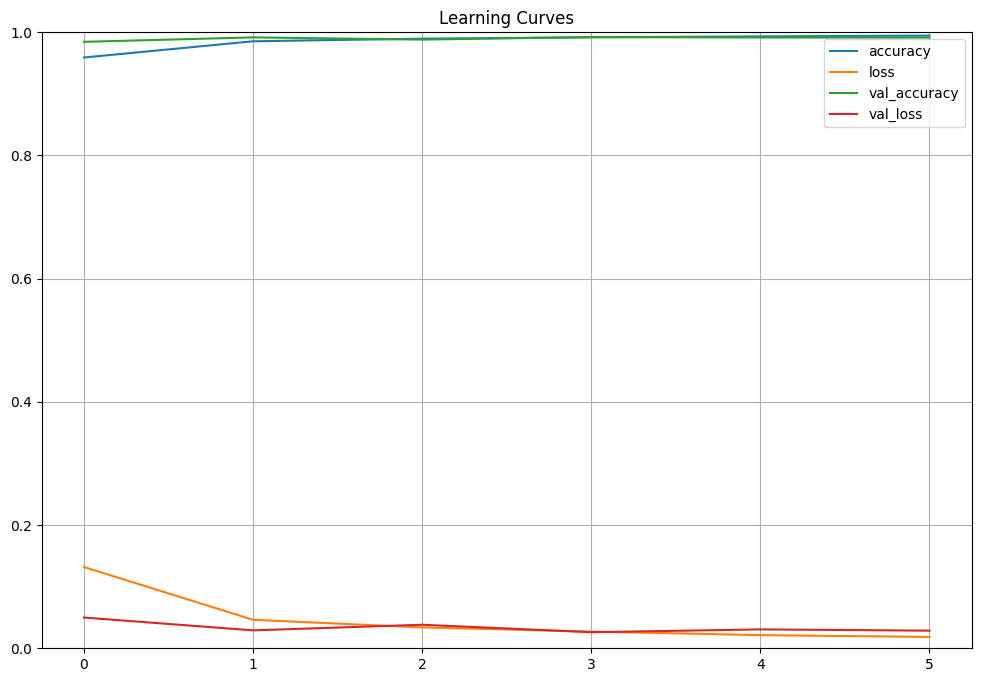

In [67]:
history = pd.DataFrame(history.history)
history.plot(figsize=(12, 8),grid=True, title="Learning Curves",ylim=(0,1))

En esta curva de aprendizaje podemos observar que el modelo tiene un pequeño overfitting ya que al final del grafico, la curva de la asertividad termina en una posicion superior a la asertividad del validation, por lo que este modelo seria un modelo utilizable y util.

In [72]:
n = len(X_test)
z = 1.96

confidence_interval = z * np.sqrt((test_acc * (1 - test_acc)) / n)
lower_bound = test_acc - confidence_interval
upper_bound = test_acc + confidence_interval

print(f"Precisión del modelo en el conjunto de prueba: {test_acc * 100:.2f}%")
print(f"Intervalo de confianza para la precisión: ({lower_bound * 100:.2f}%, {upper_bound * 100:.2f}%)")

Precisión del modelo en el conjunto de prueba: 99.13%
Intervalo de confianza para la precisión: (98.95%, 99.31%)


# Predicciones

In [75]:
X_test_50 = np.expand_dims(X_test[50], axis=-1) 
X_test_150 = np.expand_dims(X_test[150], axis=-1)

pred_class_50 = np.argmax(mejor_arquitectura.predict(X_test_50[np.newaxis, ...]))
pred_class_150 = np.argmax(mejor_arquitectura.predict(X_test_150[np.newaxis, ...]))

print(f'Predicción para X_test[50]: {pred_class_50} y la Clase era {y_test[50]}')
print(f'Predicción para X_test[150]: {pred_class_150}y la Clase era {y_test[150]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicción para X_test[50]: 6 y la Clase era 6
Predicción para X_test[150]: 9y la Clase era 9


Podemos observar que realiza una prediccion correcta en los casos del test en 150 y 50.\
Siendo la posicion 50: 6 y la predicha: 6 \
Siendo la posicion 150: 9 y la predicha: 9

# Entrenamiento con la totalidad de Datos

In [80]:
modelo_produccion = tuner.hypermodel.build(mejores_hiperparametros)

modelo_produccion.compile(loss="sparse_categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))

modelo_produccion.fit(X, y, epochs=6)

Epoch 1/6
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - accuracy: 0.9040 - loss: 0.2853
Epoch 2/6
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - accuracy: 0.9865 - loss: 0.0441
Epoch 3/6
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 30s 14ms/step - accuracy: 0.9900 - loss: 0.0319
Epoch 4/6
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 29s 13ms/step - accuracy: 0.9929 - loss: 0.0239
Epoch 5/6
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 29s 13ms/step - accuracy: 0.9946 - loss: 0.0197
Epoch 6/6
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 29s 13ms/step - accuracy: 0.9959 - loss: 0.0148


# Guardado del modelo de produccion

In [81]:
modelo_produccion.save('modelo_produccion.h5')

# Reduccion de Dimensionalidad

In [96]:
from sklearn.decomposition import PCA

pca = PCA(n_components=200)
X_train_pca = pca.fit_transform(X_train.reshape(X_train.shape[0], -1))

# Evaluacion con la reducccion de datos producida

In [99]:
modelo_dr = Sequential([
    Dense(128, input_shape=(200,), activation="relu", kernel_initializer='glorot_uniform'),
    Dense(128, activation="relu", kernel_initializer='glorot_uniform'),
    Dense(32, activation="relu", kernel_initializer='glorot_uniform'),
    Dense(10, activation="softmax", kernel_initializer='glorot_uniform')
])

modelo_dr.compile(loss="sparse_categorical_crossentropy",
                  optimizer="adam",
                  metrics=["accuracy"])

modelo_dr.fit(X_train_pca, y_train, epochs=6)



Epoch 1/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 669us/step - accuracy: 0.8407 - loss: 0.5102
Epoch 2/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 668us/step - accuracy: 0.9737 - loss: 0.0888
Epoch 3/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 626us/step - accuracy: 0.9833 - loss: 0.0520
Epoch 4/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 629us/step - accuracy: 0.9889 - loss: 0.0348
Epoch 5/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 630us/step - accuracy: 0.9905 - loss: 0.0282
Epoch 6/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 661us/step - accuracy: 0.9932 - loss: 0.0205


In [100]:
reduced_test_loss, reduced_test_acc = modelo_dr.evaluate(pca.transform(X_test.reshape(X_test.shape[0], -1)), y_test)
print(f'Accuracy con datos reducidos: {reduced_test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step - accuracy: 0.9654 - loss: 0.1317
Accuracy con datos reducidos: 0.9714000225067139


Aqui podemos ver que con el mejor modelo, con los datos reducidos a 200 pixeles, nos da una asertividad del 97%

Al ser el resultado anterior con el modelo entrenado sin los datos reducidos (98.95%, 99.31%), y con los datos reducidos 97% tenemos una diminuta diferencia ca favor de los datos sin reducir

# Conclusion

El modelo tiene una precisión (accuracy) del 99.13%, con un intervalo de confianza para la precisión que varía entre 98.95% y 99.32%, lo que sugiere que, para datos nuevos, se espera que el rendimiento del modelo se mantenga dentro de este rango con un nivel de confianza adecuado.